In [1]:
import pandas as pd

In [2]:
crime_time_series = pd.read_csv("crime_weather_weekly_time_series")
print(crime_time_series.columns)
print(crime_time_series.shape[0])

Index(['census_block_numeric', 'date', 'dow_sin', 'dow_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'week_precipitation_interaction', 'daylight_precipitation_interaction',
       'block_week_interaction', 'block_temp_max_interaction', 'temp_range',
       'temp_range_precipitation_interaction', 'is_holiday', 'week_of_year',
       'Crime_Count_W', 'Crime_Count_W_lag1w', 'Crime_Count_W_lag4w',
       'Crime_Count_W_lag12w', 'Crime_Count_W_lag24w', 'Crime_Count_W_lag52w',
       'Crime_Count_W_rolling2', 'Crime_Count_W_rolling3',
       'Crime_Count_W_rolling4', 'Crime_Count_W_rolling8',
       'Crime_Count_W_rolling15', 'week_rolling2_interaction',
       'temp_rolling2_interaction', 'precip_rolling2_interaction',
       'week_rolling3_interaction', 'temp_rolling3_interaction',
       'precip_rolling3_interaction', 'week_rolling4_interaction',
       'temp_rolling4_inte

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_cross_validation(model, X, y, k=5):
    tscv = TimeSeriesSplit(n_splits=k)
    fold_metrics = []
    feature_importances_by_fold = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = []
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Analyze the last part of Fold 1
        #last_part = X_test  # Adjust index range for your data
        #print(last_part.describe())  # Check statistical properties
        #print(y_test.describe())

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))
        
        # Save feature importances for this fold
        feature_importances = model['model'].feature_importances_
        feature_importances_by_fold.append(feature_importances)

        # Plot residuals
        residuals = np.array(y_test) - np.array(y_pred)
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(residuals)), residuals, alpha=0.5, label=f"Fold {fold + 1}")
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
        plt.title(f'Residuals for Fold {fold + 1}')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Residual (Actual - Predicted)')
        plt.legend()
        plt.show()

    # Plot overall residuals
    plt.figure(figsize=(12, 6))
    plt.plot(all_y_test, label='Actual')
    plt.plot(all_y_pred, label='Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.xlabel('Time (Ordered Test Samples)')
    plt.ylabel('Values')
    plt.show()

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    """
    # Display feature importance by fold
    for fold, importances in enumerate(feature_importances_by_fold, start=1):
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print(f"Feature Importances for Fold {fold}:")
        print(importance_df)
    """

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [4]:
# Define features (excluding 'census_block_numeric' if you choose)
# List of feature names
features = [
    "dow_cos", "dow_sin", "precipitation_hours",
    "Crime_Count_W_rolling15", "Crime_Count_W_rolling8", "Crime_Count_W_rolling4",
    "day_cos", "Crime_Count_W_rolling3", "Crime_Count_W_rolling2",
    "temp_rolling15_interaction", "temp_rolling4_interaction", "temp_rolling3_interaction",
    "temp_rolling2_interaction", "precip_rolling2_interaction", "Crime_Count_W_lag1w",
    "Crime_Count_W_lag4w", "day_sin", "daylight_lag1_interaction", "precip_rolling3_interaction",
    "daylight_lag12_interaction", "daylight_lag4_interaction", "daylight_lag24_interaction",
    "Crime_Count_W_lag52w", "precip_rolling4_interaction", "Crime_Count_W_lag12w",
    "precipitation_sum", "Crime_Count_W_lag24w", "daylight_lag52_interaction",
    "temp_range", "precip_rolling15_interaction"
]

# Define categorical features
categorical_features = ['census_block_numeric']  # Add more if applicable
                   
X = crime_time_series[features + categorical_features]
y = crime_time_series['Crime_Count_W']

In [77]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

# Define frequency encoding as a custom transformer
def frequency_encode(X, categorical_features):
    X_encoded = X.copy()
    for col in categorical_features:
        freq_map = X[col].value_counts(normalize=False).to_dict()
        X_encoded[col] = X[col].map(freq_map)
    return X_encoded

# Wrap the frequency encoding logic into a FunctionTransformer
frequency_encoder = FunctionTransformer(lambda X: frequency_encode(X, categorical_features), validate=False)

# Define the pipeline
pipeline = Pipeline([
    ('frequency_encoder', frequency_encoder),
    ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
])

# Define parameter distributions for randomized search
param_grid = {
    'model__n_estimators': [100, 300, 350, 400, 500],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Implement GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    return_train_score=False
)

# Fit RandomizedSearchCV
grid_search.fit(X, y)

# Extract best parameters and score
print(f"Best MAE Score: {-grid_search.best_score_:.4f}")
print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
    
best_params = {key.replace('model__', ''): value for key, value in grid_search.best_params_.items()}

Fitting 5 folds for each of 10935 candidates, totalling 54675 fits
Best MAE Score: 0.2485
Best Parameters:
  model__colsample_bytree: 0.6
  model__gamma: 0
  model__learning_rate: 0.2
  model__max_depth: 6
  model__n_estimators: 500
  model__reg_alpha: 0
  model__reg_lambda: 1.5
  model__subsample: 1.0


In [6]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

# Define frequency encoding as a custom transformer
def frequency_encode(X, categorical_features):
    X_encoded = X.copy()
    for col in categorical_features:
        freq_map = X[col].value_counts(normalize=False).to_dict()
        X_encoded[col] = X[col].map(freq_map)
    return X_encoded

# Wrap the frequency encoding logic into a FunctionTransformer
frequency_encoder = FunctionTransformer(lambda X: frequency_encode(X, categorical_features), validate=False)

# Define the pipeline
pipeline = Pipeline([
    ('frequency_encoder', frequency_encoder),
    ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
])

# Define parameter distributions for randomized search
param_distributions = {
    'model__n_estimators': randint(50, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'model__subsample': uniform(0.6, 0.4),        # 0.6 to 1.0
    'model__colsample_bytree': uniform(0.6, 0.4), # 0.6 to 1.0
    'model__gamma': uniform(0, 1),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1.5)
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Implement RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Adjust based on available resources
    scoring=scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=False
)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Extract best parameters and score
print(f"Best MAE Score: {-random_search.best_score_:.4f}")
print("Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
    
best_params = {key.replace('model__', ''): value for key, value in random_search.best_params_.items()}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score: 0.2585
Best Parameters:
  model__colsample_bytree: 0.6727299868828402
  model__gamma: 0.18340450985343382
  model__learning_rate: 0.06780602616231217
  model__max_depth: 8
  model__n_estimators: 302
  model__reg_alpha: 0.43194501864211576
  model__reg_lambda: 0.43684371029706287
  model__subsample: 0.8447411578889518


Fold 1 Metrics:
  Mean Absolute Error (MAE): 0.31021667547487974
  Root Mean Squared Error (RMSE): 0.369784534403495
  R² Score: 0.8458390772425557



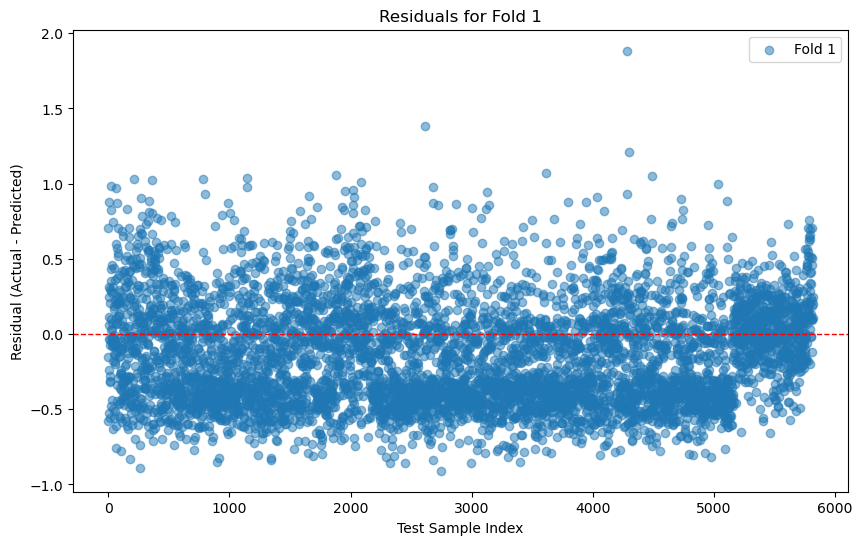

Fold 2 Metrics:
  Mean Absolute Error (MAE): 0.2534444242200881
  Root Mean Squared Error (RMSE): 0.3234632653506779
  R² Score: 0.8446420483386254



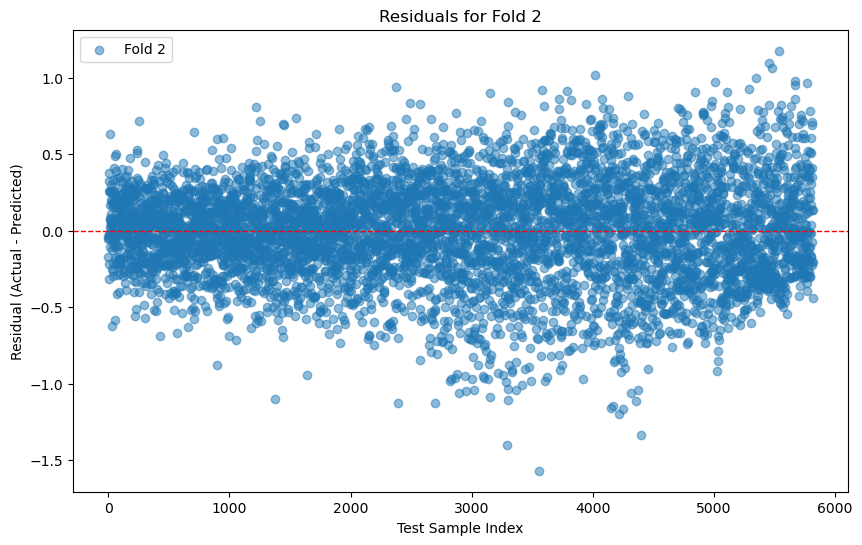

Fold 3 Metrics:
  Mean Absolute Error (MAE): 0.2522621081379741
  Root Mean Squared Error (RMSE): 0.3168351931589423
  R² Score: 0.8904297432827835



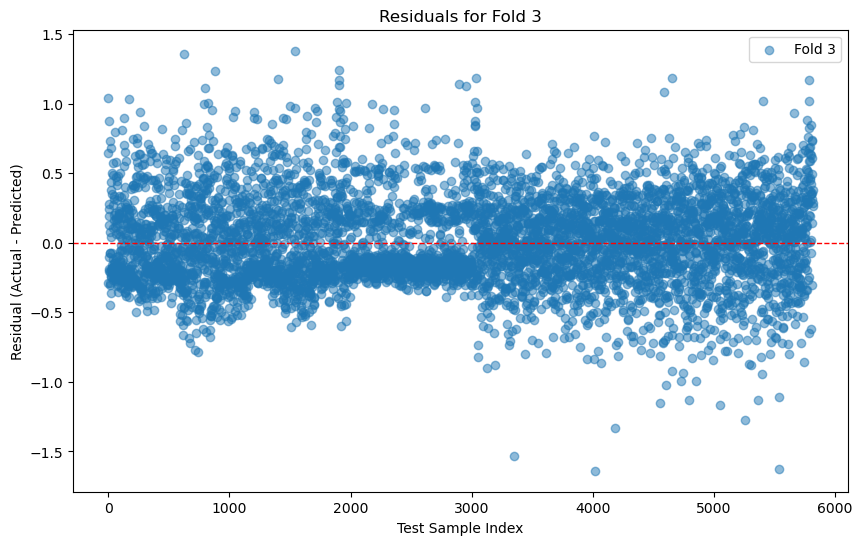

Fold 4 Metrics:
  Mean Absolute Error (MAE): 0.2538509601639041
  Root Mean Squared Error (RMSE): 0.3135022109604342
  R² Score: 0.7684131926222291



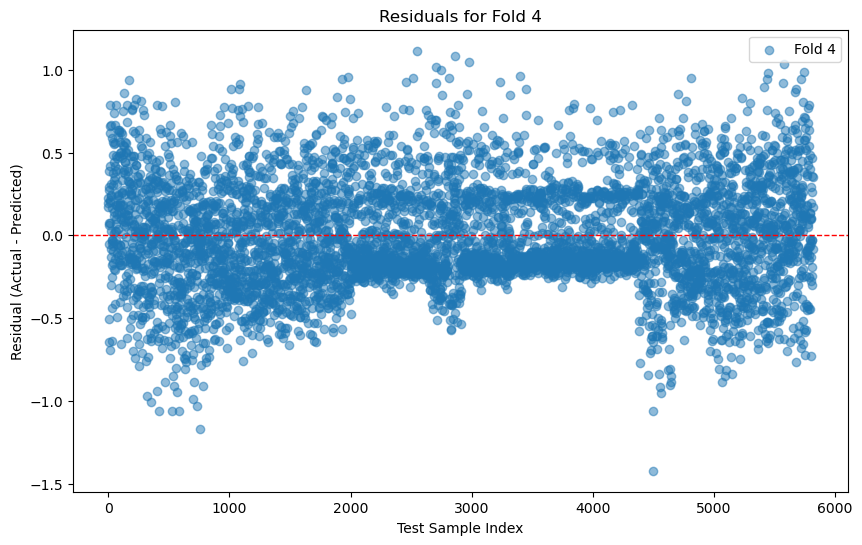

Fold 5 Metrics:
  Mean Absolute Error (MAE): 0.22251256635045855
  Root Mean Squared Error (RMSE): 0.27737469356103023
  R² Score: 0.7791088250170763



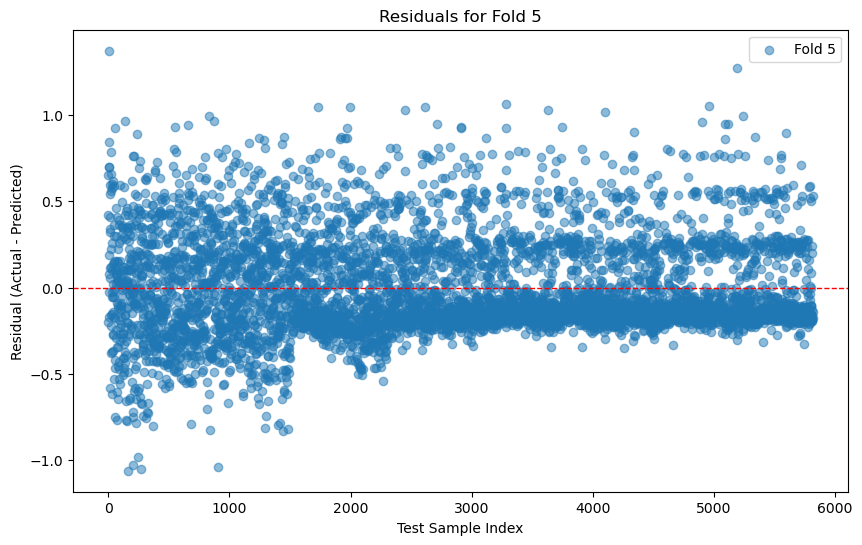

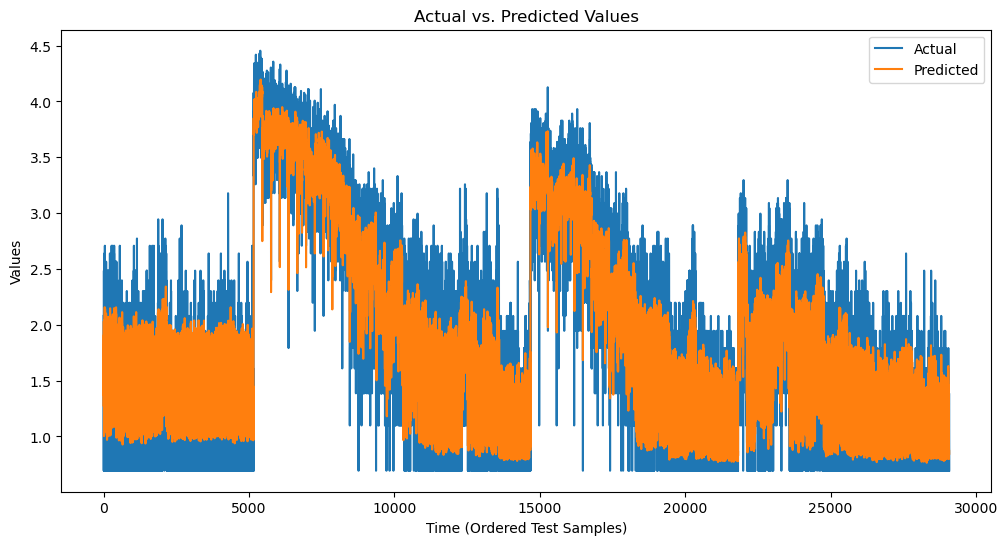

Average MAE across 5 folds: 0.2584573468694609
Average RMSE across 5 folds: 0.3201919794869159
Average R² Score across 5 folds: 0.825686577300654


In [7]:
from xgboost import XGBRegressor

xgb_model = random_search.best_estimator_

avg_mae, avg_rmse, avg_r2, metrics = time_series_cross_validation(xgb_model, X, y)

In [7]:
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Calculate MAE per block using groupby and apply for vectorization
block_mae = crime_time_series.groupby('census_block_numeric').apply(
    lambda group: mean_absolute_error(y.loc[group.index], xgb_model.predict(X.loc[group.index]))
).reset_index(name='MAE')

# Merge MAE back into crime_time_series
crime_time_series = crime_time_series.merge(block_mae, on='census_block_numeric', how='left')

# Apply smoothing to MAE to reduce variance for blocks with few samples
# Smoothing formula: (sum(MAE) + global_MAE * smoothing_factor) / (count + smoothing_factor)
smoothing_factor = 3
global_mae = block_mae['MAE'].mean()
block_counts = crime_time_series['census_block_numeric'].value_counts().reset_index()
block_counts.columns = ['census_block_numeric', 'count']

# Merge counts with MAE
block_mae = block_mae.merge(block_counts, on='census_block_numeric', how='left')

# Calculate smoothed MAE
block_mae['MAE_smooth'] = (block_mae['MAE'] * block_mae['count'] + global_mae * smoothing_factor) / (block_mae['count'] + smoothing_factor)

# Merge smoothed MAE back into crime_time_series
crime_time_series = crime_time_series.merge(block_mae[['census_block_numeric', 'MAE_smooth']], on='census_block_numeric', how='left')

scaler = RobustScaler()
crime_time_series['sample_weight'] = scaler.fit_transform(crime_time_series[['MAE_smooth']])

max_weight = 5
# Optional: Clip weights to a maximum value
crime_time_series['sample_weight'] = crime_time_series['sample_weight'].clip(1, max_weight)

# Extract sample_weight
sample_weight = crime_time_series['sample_weight']

# Train the model with sample weights
xgb_model.fit(X, y)

C:\Users\singh\AppData\Local\Temp\ipykernel_448288\1520112611.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  block_mae = crime_time_series.groupby('census_block_numeric').apply(


Pipeline(steps=[('frequency_encoder',
                 FunctionTransformer(func=<function <lambda> at 0x0000025C227655E0>)),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6727299868828402, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=Non...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.06780602616231217, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=302, n_jobs=None,
                              num_parallel_tree=None, objective='count:poisson', ...))])

In [8]:
# List of feature names
features = [
    "dow_cos", "dow_sin", "precipitation_hours", "census_block_numeric",
    "Crime_Count_W_rolling15", "Crime_Count_W_rolling8", "Crime_Count_W_rolling4",
    "day_cos", "Crime_Count_W_rolling3", "Crime_Count_W_rolling2",
    "temp_rolling15_interaction", "temp_rolling4_interaction", "temp_rolling3_interaction",
    "temp_rolling2_interaction", "precip_rolling2_interaction", "Crime_Count_W_lag1w",
    "Crime_Count_W_lag4w", "day_sin", "daylight_lag1_interaction", "precip_rolling3_interaction",
    "daylight_lag12_interaction", "daylight_lag4_interaction", "daylight_lag24_interaction",
    "Crime_Count_W_lag52w", "precip_rolling4_interaction", "Crime_Count_W_lag12w",
    "precipitation_sum", "Crime_Count_W_lag24w", "daylight_lag52_interaction",
    "temp_range", "precip_rolling15_interaction", 'sample_weight'
]

X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

In [9]:
crime_time_series = crime_time_series.drop(columns=['MAE', 'MAE_smooth'])

In [10]:
# Define frequency encoding as a custom transformer
def frequency_encode(X, categorical_features):
    X_encoded = X.copy()
    for col in categorical_features:
        freq_map = X[col].value_counts(normalize=False).to_dict()
        X_encoded[col] = X[col].map(freq_map)
    return X_encoded

# Wrap the frequency encoding logic into a FunctionTransformer
frequency_encoder = FunctionTransformer(lambda X: frequency_encode(X, categorical_features), validate=False)

# Define the pipeline
pipeline = Pipeline([
    ('frequency_encoder', frequency_encoder),
    ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
])

# Define parameter distributions for randomized search
param_distributions = {
    'model__n_estimators': randint(50, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'model__subsample': uniform(0.6, 0.4),        # 0.6 to 1.0
    'model__colsample_bytree': uniform(0.6, 0.4), # 0.6 to 1.0
    'model__gamma': uniform(0, 1),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1)
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Implement RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Adjust based on available resources
    scoring=scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=False
)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Extract best parameters and score
print(f"Best MAE Score: {-random_search.best_score_:.4f}")
print("Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
    
best_params = {key.replace('model__', ''): value for key, value in random_search.best_params_.items()}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score: 0.2587
Best Parameters:
  model__colsample_bytree: 0.8599094730571053
  model__gamma: 0.048058924197033726
  model__learning_rate: 0.19033768900236334
  model__max_depth: 6
  model__n_estimators: 339
  model__reg_alpha: 0.26089362334171395
  model__reg_lambda: 0.01530454029038475
  model__subsample: 0.9733745232317932


Fold 1 Metrics:
  Mean Absolute Error (MAE): 0.3125206441678062
  Root Mean Squared Error (RMSE): 0.3755785651324824
  R² Score: 0.8409702373133121



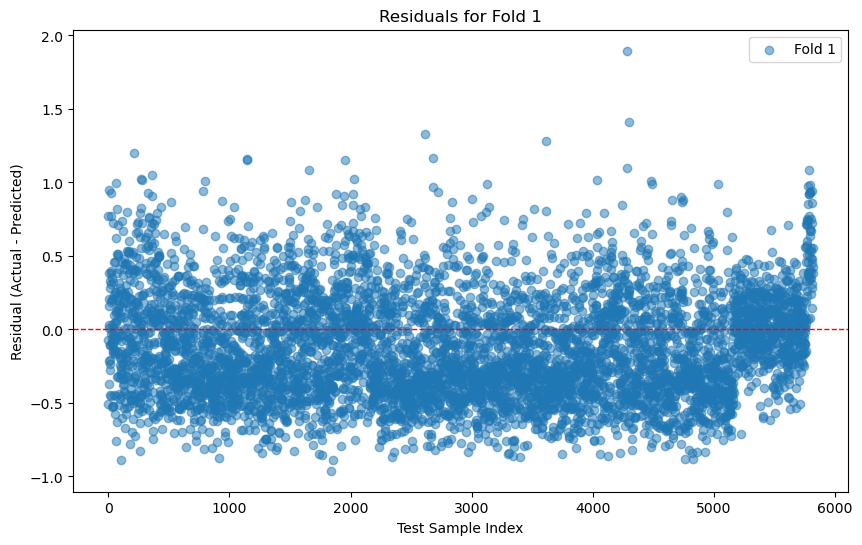

Fold 2 Metrics:
  Mean Absolute Error (MAE): 0.25445545739150843
  Root Mean Squared Error (RMSE): 0.32539709496748254
  R² Score: 0.8427788761009715



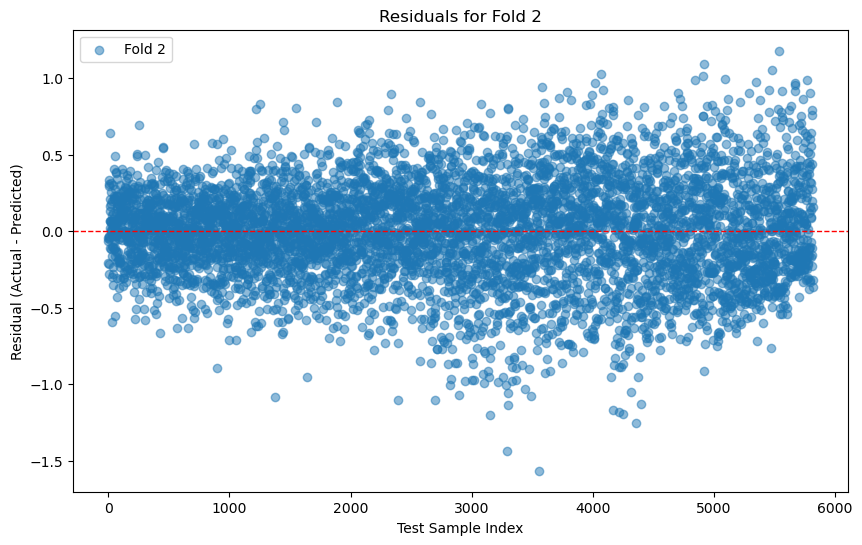

Fold 3 Metrics:
  Mean Absolute Error (MAE): 0.2523647841497558
  Root Mean Squared Error (RMSE): 0.31748368868869425
  R² Score: 0.8899807493488334



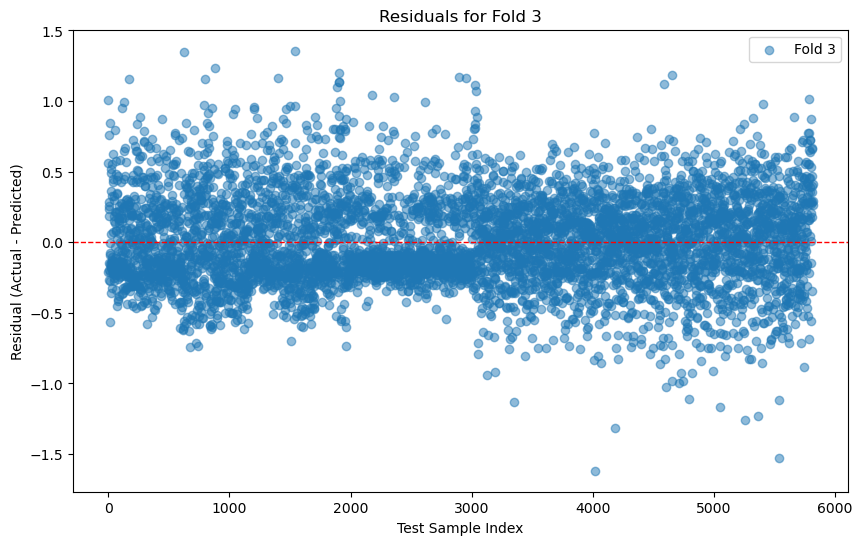

Fold 4 Metrics:
  Mean Absolute Error (MAE): 0.25064324551242845
  Root Mean Squared Error (RMSE): 0.31033530037190654
  R² Score: 0.7730684091599872



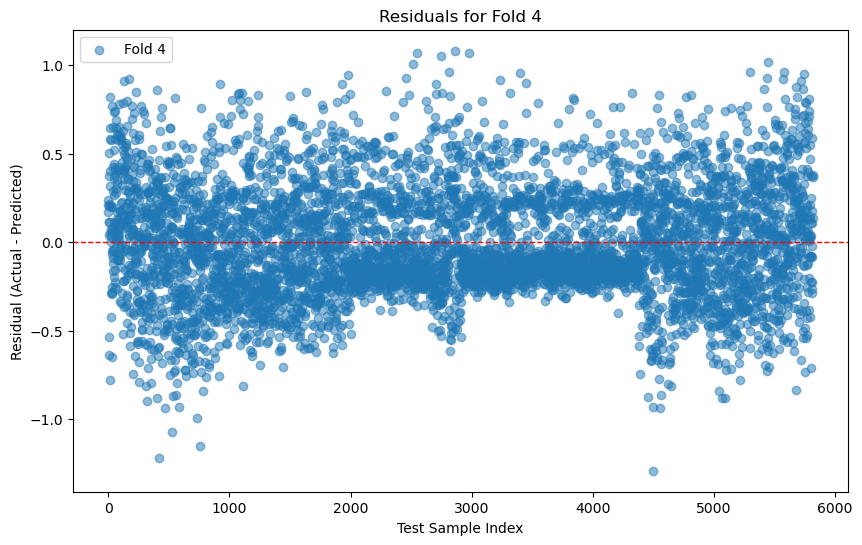

Fold 5 Metrics:
  Mean Absolute Error (MAE): 0.22373197860133365
  Root Mean Squared Error (RMSE): 0.27835206971413123
  R² Score: 0.7775493883360187



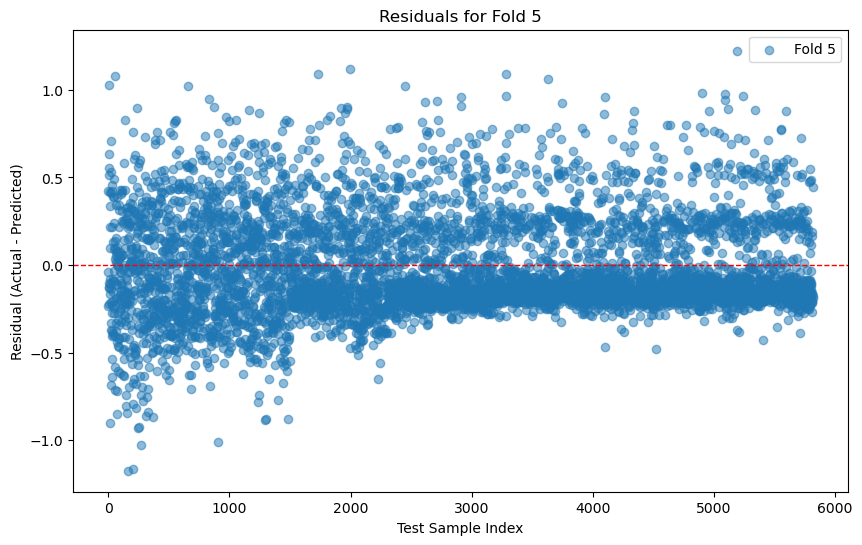

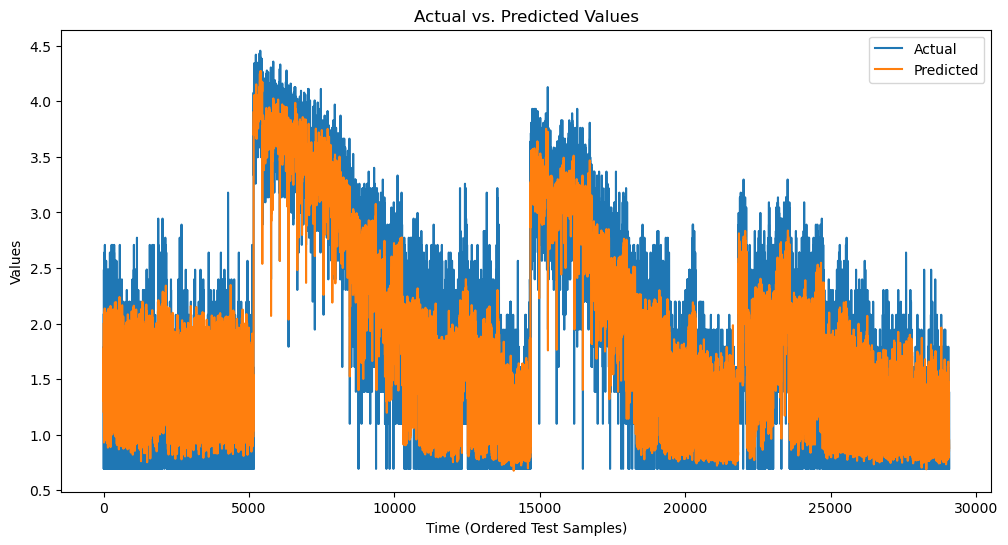

Average MAE across 5 folds: 0.2587432219645665
Average RMSE across 5 folds: 0.3214293437749394
Average R² Score across 5 folds: 0.8248695320518247


In [11]:
from xgboost import XGBRegressor

avg_mae, avg_rmse, avg_r2, metrics = time_series_cross_validation(random_search.best_estimator_, X, y)